# Gabe, develop this script!
Alot of this is working in the other script but needs to be checked. The GPIO is really what needs work.

In [1]:
# Imports
import numpy as np
import scipy
import scipy.signal as signal
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.interpolate import CubicSpline
from scipy.signal import hilbert
import numpy as np
import ipywidgets as ipw
import base64
from random import randint
from pynq import Clocks
import xrfdc
import xrfclk
import os
from pynq.lib import Pmod_IO
from pynq.lib import AxiGPIO
import time

# Use the RFSoC base overlay
# from pynq.overlays.base import BaseOverlay
# beamforming = BaseOverlay('beamforming.bit')

from pynq import Overlay
beamforming = Overlay('beamforming.bit')

# Start RF clocks
beamforming.init_rf_clks()

# The below block doesn't need changes
Change sample_scaler to reduce/increase number_samples.
Change adc_array to change which ADCs you're using.

In [2]:
beamforming?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff88c843a0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay beamforming.bit. The following
attributes are available on this overlay:

IP Blocks
----------
imag_bWeights        : pynq.lib.axigpio.AxiGPIO
real_bWeights        : pynq.lib.axigpio.AxiGPIO
CMAC/axi_dma         : pynq.lib.dma.DMA
CMAC/cmac            : pynq.lib.cmac.CMAC
radio/receiver/channel_00/axi_dma_imag : pynq.lib.dma.DMA
radio/receiver/channel_00/axi_dma_real : pynq.lib.dma.DMA
radio/receiver/channel_00/packet_generator : pynq.overlay.DefaultIP
radio/receiver/channel_01/axi_dma_imag : pynq.lib.dma.DMA
radio/receiver/channel_01/axi_dma_real : pynq.lib.dma.DMA
radio/receiver/channel_01/packet_generator : pynq.overlay.DefaultIP
radio/receiver/channel_20/axi_dma_imag : pynq.lib.dma.DMA
radio/receiver/channel_20/axi_dma_real : pynq.lib.dma.DMA
radio/receive

In [3]:
# ADC initialization
# Channels
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}

ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0} ch00
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1} ch01
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0} ch20
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1} ch21

adc_array = [ADC_CHANNEL_D, ADC_CHANNEL_C, ADC_CHANNEL_B, ADC_CHANNEL_A]

adc_char_array = ['D', 'C', 'B', 'A']

sample_scaler = 32
number_samples = int(32768/sample_scaler)  # Between 16 and 32768
decimation_factor = 1 # 2 is default
sample_frequency = 4915.2e6/decimation_factor  # Hz The default sample frequency is 4915.2e6 Hz which is sufficient for our signal

original_adc_settings = beamforming.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings

for ADC in adc_array:
    beamforming.radio.receiver.channel[ADC].adc_block.DecimationFactor = decimation_factor
    beamforming.radio.receiver.channel[ADC].adc_block.MixerSettings = {
        'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
        'EventSource':    xrfdc.EVNT_SRC_TILE, 
        'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
        'Freq':           0.0,
        'MixerMode':      xrfdc.MIXER_MODE_R2C,
        'MixerType':      xrfdc.MIXER_TYPE_FINE,
        'PhaseOffset':    0.0
    }
    beamforming.radio.receiver.channel[ADC].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
    
# print("Original ADC settings:", original_adc_settings)
# print("New ADC settings:", beamforming.radio.receiver.channel[ADC].adc_block.MixerSettings)

AttributeError: Could not find IP or hierarchy channel in overlay

# Calculate beamforming weights
Use steering angle, careful attention needed when passing them into GPIO to handle -30 vs 30 degrees case.

In [15]:
d = 0.5 # half wavelength spacing
Nr = len(adc_array)
steering_angle_degrees = int(input("Input the steering angle in degrees:"))
steering_angle = steering_angle_degrees / 180 * np.pi # convert to radians
beamforming_weights = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(steering_angle)) # array factor
print("beamforming_weights:", beamforming_weights)
    

Input the steering angle in degrees: 1


beamforming_weights: [1.        +0.j         0.9984973 -0.05480089j 0.99399373-0.10943707j
 0.98650281-0.16374436j]


# Pass them into GPIO
Work closely with Katie on this. See this link: https://pynq.readthedocs.io/en/latest/pynq_libraries/psgpio.html

In [16]:
beamforming.dma.description

dma = beamforming.dma.register_map
# help(dma)
print(dma)

# S2MM is what we care about (read operations)


AttributeError: Could not find IP or hierarchy dma in overlay

In [17]:
real_ip = beamforming.ip_dict['real_bWeights'] # real_bWeights
imag_ip = beamforming.ip_dict['imag_bWeights'] # imag_bWeights

real = AxiGPIO(real_ip).channel1
imag = AxiGPIO(imag_ip).channel1

zeroed_weights = []
for ADC in adc_array:
    zeroed_weights.append(0+0j)
    
beamforming_weights = zeroed_weights

b_real = 0
b_imag = 0
if steering_angle_degrees > 0:
    for ADC in adc_array:
        if ADC == 0:
            shift = 24
        elif ADC == 1:
            shift = 16
        elif ADC == 2:
            shift = 8
        elif ADC == 3:
            shift = 0
        b_real = b_real | int(np.real(beamforming_weights[ADC])) << shift
        b_imag = b_imag | int(np.imag(beamforming_weights[ADC])) << shift
else:
    for ADC in adc_array:
        if ADC == 0:
            shift = 0
        elif ADC == 1:
            shift = 8
        elif ADC == 2:
            shift = 16
        elif ADC == 3:
            shift = 24
        b_real = b_real | int(np.real(beamforming_weights[ADC])) << shift
        b_imag = b_imag | int(np.imag(beamforming_weights[ADC])) << shift
real.write(0xffffffff, b_real)
print("b_real:", b_real)
imag.write(0xffffffff, b_imag)
print("b_imag:", b_imag)


b_real: 0
b_imag: 0


In [18]:
beamforming.real_bWeights.register_map
beamforming.imag_bWeights.register_map

RegisterMap {
  GPIO_DATA = Register(Channel_1_GPIO_DATA=0),
  GPIO_TRI = Register(Channel_1_GPIO_TRI=4294967295),
  GPIO2_DATA = Register(Channel_2_GPIO_DATA=0),
  GPIO2_TRI = Register(Channel_2_GPIO_TRI=4294967295),
  GIER = Register(Global_Interrupt_Enable=1),
  IP_ISR = Register(Channel_1_Interrupt_Status=0, Channel_2_Interrupt_Status=0),
  IP_IER = Register(Channel_1_Interrupt_Enable=0, Channel_2_Interrupt_Enable=0)
}

# Transfer data from channel that Katie ports beamforming data to


AttributeError: Could not find IP or hierarchy dma in overlay

In [20]:
beamforming.CMAC.axi_dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=1, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=1, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [22]:
beamforming.CMAC.axi_dma.set_up_rx_channel()
beamforming.CMAC.axi_dma.recvchannel.start()

In [23]:
beamformed_data = []
# Something like this:

beamformed_data.append(beamforming.radio.receiver.channel[1].transfer(number_samples))
print(beamformed_data[0])

RuntimeError: DMA channel not started

# Plot beamformed data
Also add code to calculate max power

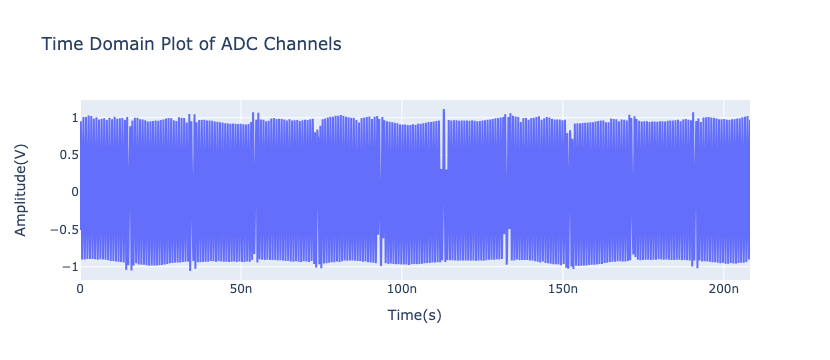

In [18]:
beamformed_interpolated_data = []

# Create Plotly figure for interpolated ADC data
beamformed_fig = make_subplots(specs=[[{"secondary_y": False}]])  # Adjust as necessary

# Needed for interpolation

time_data = np.arange(0, number_samples/sample_frequency, 1/sample_frequency)
dense_t = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)  # Increase density
    
sampled_signal = np.real(beamformed_data[0])
cs_real = CubicSpline(time_data, sampled_signal)

# Beamformed interpolated data
beamformed_interpolated_data.append(cs_real(dense_t))

# Add beamformed interpolated data trace
beamformed_fig.add_trace(
go.Scatter(x=dense_t, y=beamformed_interpolated_data[0], name=f"Beamformed Interpolated Data"),
secondary_y=False,
)

# Update layout of raw ADC data
beamformed_fig.update_layout(
title=f"Time Domain Plot of ADC Channels",
xaxis_title="Time(s)",
yaxis_title="Amplitude(V)",
)

# Show beamformed ADC data
beamformed_fig.show()  

# Can also plot raw data by plotting data from a channel that isn't being used to port beamforming data
Also add code to calculate max power

In [ ]:
raw_data = []
raw_interpolated_data = []

# Create Plotly figure for interpolated ADC data
raw_fig = make_subplots(specs=[[{"secondary_y": False}]])  # Adjust as necessary

# Needed for interpolation
time_data = np.arange(0, number_samples/sample_frequency, 1/sample_frequency)
dense_t = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)  # Increase density
    
# Get chunk of data, interpolate it, and create trace
raw_data.append(beamforming.radio.receiver.channel[ADC].transfer(number_samples))
sampled_signal = np.real(raw_data)
cs_real = CubicSpline(time_data, sampled_signal)

# Raw interpolated data
raw_interpolated_data.append(cs_real(dense_t))

# Add raw interpolated data trace
raw_fig.add_trace(
go.Scatter(x=dense_t, y=raw_interpolated_data, name=f"Interpolated Data ADC {adc_char_array[ADC]}"),
secondary_y=False,
)

# Update layout of raw ADC data
raw_fig.update_layout(
title=f"Time Domain Plot of ADC Channels",
xaxis_title="Time(s)",
yaxis_title="Amplitude(V)",
)

# Show raw ADC data
raw_fig.show() 